In [1]:
import os
import pandas as pd
from PIL import Image
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from skimage import feature
import dlib

In [2]:
# Define emotion labels corresponding to subdirectories
emotion_labels = {'anger':0, 'disgust':1, 'fear':2, 'happy':3, 'sadness':4, 'surprise':5, 'contempt':6}
# Define a mapping dictionary from numeric labels to emotion names
emotion_names = {0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sadness', 5: 'surprise', 6: 'contempt'}

In [3]:
# Define the root directory where the fer2013 dataset images are stored
# Adjust the path to the actual dataset directory
dataset_dir = './CK/'

In [4]:
# Initialize empty lists to store image data and labels
images = []
labels = []
lbp_images = []
lbp_histograms = []
lbp_features = []

In [5]:
# Iterate through subdirectories and load images and labels
for emotion, label in emotion_labels.items():
    subdirectory_path = os.path.join(dataset_dir, emotion)
    
    # Iterate through images in each subdirectory
    for image_filename in os.listdir(subdirectory_path):
        image_path = os.path.join(subdirectory_path, image_filename)
        
        # Open and preprocess the image (you may need to resize or convert to grayscale)
        image = cv2.imread(image_path)
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Append the image and its label to the lists
        image = np.array(image)  # Convert to NumPy array if needed
        images.append(image)
        labels.append(label)  # Convert emotion label to integer

In [6]:
# Convert lists to NumPy arrays for further processing
images = np.array(images)
labels = np.array(labels)
num_samples = len(images)

# Check the shapes of the arrays
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

Images shape: (981, 48, 48)
Labels shape: (981,)


In [7]:
images[0].shape

(48, 48)

In [8]:
count = [0,0,0,0,0,0,0]
for i in range(num_samples):
    count[labels[i]] = count[labels[i]] + 1
for i in range(7):
    print(count[i])

135
177
75
207
84
249
54


In [9]:
r = 1
p = 8 * r

In [10]:
# Iterate through the selected sample indices
for i in range(num_samples):
    
    original_image = images[i]
    
    # Calculate LBP for the image
    lbp_image = feature.local_binary_pattern(original_image, P=p, R=r, method='uniform')
    
    # Calculate a histogram of the LBP image
    lbp_hist, _ = np.histogram(lbp_image.ravel(), bins=np.arange(0, p+2), range=(0, p+3))
    
    # Normalize the histogram to obtain a feature vector
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)  # Avoid division by zero
    
    
    # Append the LBP image to the list
    lbp_images.append(lbp_image)
    
    # Append the normalized LBP histogram to the list
    lbp_histograms.append(lbp_hist)

In [11]:
# Convert the list of histogram vectors to a NumPy array
lbp_histograms = np.array(lbp_histograms)

# Now, 'lbp_histograms' contains the LBP histogram for each image in your dataset
print("LBP Histograms shape:", lbp_histograms.shape)

LBP Histograms shape: (981, 9)


In [12]:
# Convert the list of LBP images to a NumPy array
lbp_images = np.array(lbp_images)

# Now, 'lbp_images' contains the LBP representations of all images
print("LBP Images shape:", lbp_images.shape)

LBP Images shape: (981, 48, 48)


In [13]:
# You can access individual original and LBP images by indexing the arrays
# For example, to access the first original and LBP images:
index = random.randint(0, num_samples-1)
original_image = images[index]
lbp_image = lbp_images[index]
lbp_hist = lbp_histograms[index]
numeric_label = labels[index]
# Get the emotion name or 'Unknown' if not found
emotion_name = emotion_names.get(numeric_label, 'Unknown')

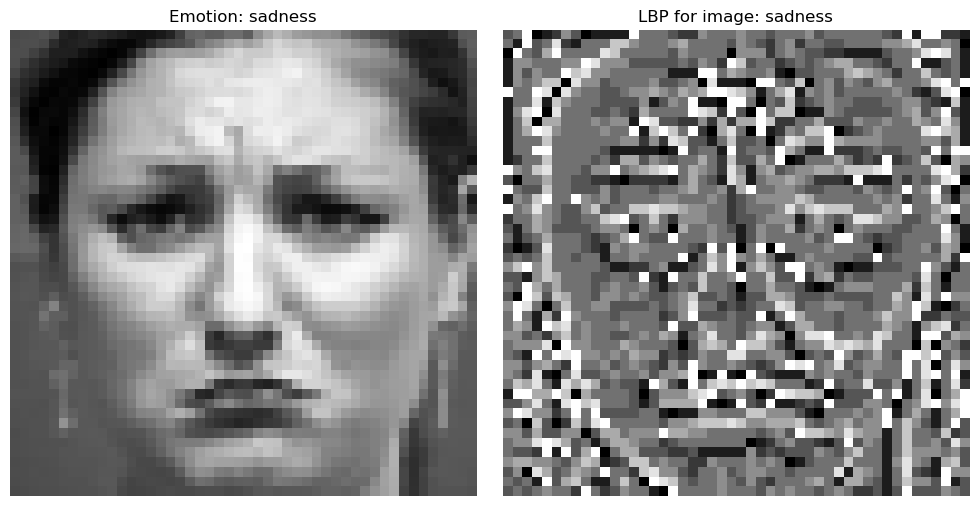

In [14]:
# Create subplots for the random image and its LBP representation
fig, axes = plt.subplots(1, 2, figsize=(10, 5)) 

# Display the original image
ax_original = axes[0]
ax_original.imshow(original_image, cmap='gray')
ax_original.set_title(f"Emotion: {emotion_name}")
ax_original.axis('off')
    
# Display the LBP representation
ax_lbp = axes[1]
ax_lbp.imshow(lbp_image, cmap='gray')
ax_lbp.set_title(f"LBP for image: {emotion_name}")
ax_lbp.axis('off')
 
plt.tight_layout()
plt.show()

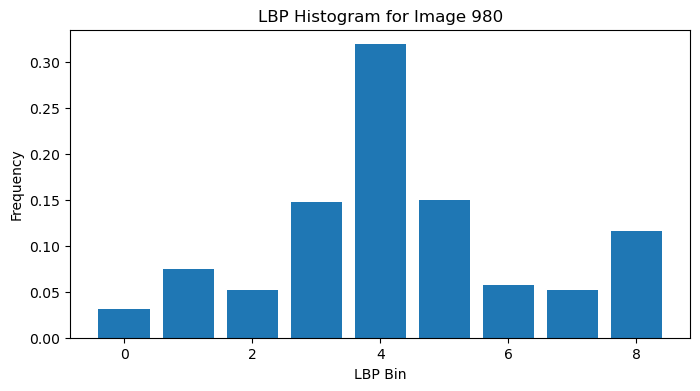

In [15]:
# Plot the histogram
plt.figure(figsize=(8, 4))
plt.bar(range(len(lbp_hist)), lbp_hist)
plt.title(f'LBP Histogram for Image {i}')
plt.xlabel('LBP Bin')
plt.ylabel('Frequency')
plt.show()

In [16]:
lbp_histograms

array([[0.02734375, 0.06727431, 0.05859375, ..., 0.05555556, 0.046875  ,
        0.13585069],
       [0.02517361, 0.07204861, 0.05381944, ..., 0.05815972, 0.04340278,
        0.13758681],
       [0.02560764, 0.06119792, 0.06206597, ..., 0.04383681, 0.04557292,
        0.13064236],
       ...,
       [0.03559028, 0.07421875, 0.05295139, ..., 0.05425347, 0.05425347,
        0.13454861],
       [0.03255208, 0.07421875, 0.06163194, ..., 0.05121528, 0.05772569,
        0.12717014],
       [0.03211806, 0.07204861, 0.06032986, ..., 0.05729167, 0.0546875 ,
        0.13671875]])

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [18]:
# Assuming 'lbp_features' contains LBP feature vectors
# Assuming 'labels' contains corresponding emotion labels
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(lbp_histograms, labels, test_size=0.2, random_state=42)

In [19]:
# Initialize and train a Support Vector Machine (SVM) classifier
svm_classifier = SVC(kernel='linear', C=1.0)
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear')

In [20]:
# Make predictions on the test data
y_pred_train = svm_classifier.predict(X_train)

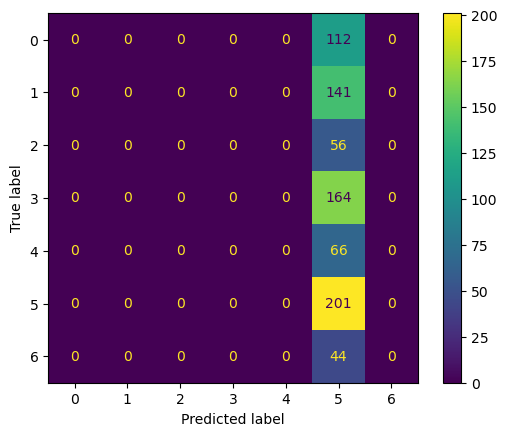

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_train, y_pred_train, labels=svm_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_classifier.classes_)
disp.plot()
plt.show()

In [22]:
# Evaluate the model
accuracy = accuracy_score(y_train, y_pred_train)
report = classification_report(y_train, y_pred_train)

print("Train Accuracy:", accuracy)
print("Classification Report:\n", report)

Train Accuracy: 0.25637755102040816
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       112
           1       0.00      0.00      0.00       141
           2       0.00      0.00      0.00        56
           3       0.00      0.00      0.00       164
           4       0.00      0.00      0.00        66
           5       0.26      1.00      0.41       201
           6       0.00      0.00      0.00        44

    accuracy                           0.26       784
   macro avg       0.04      0.14      0.06       784
weighted avg       0.07      0.26      0.10       784



C:\Users\vvsst\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vvsst\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vvsst\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
# Make predictions on the test data
y_pred_test = svm_classifier.predict(X_test)

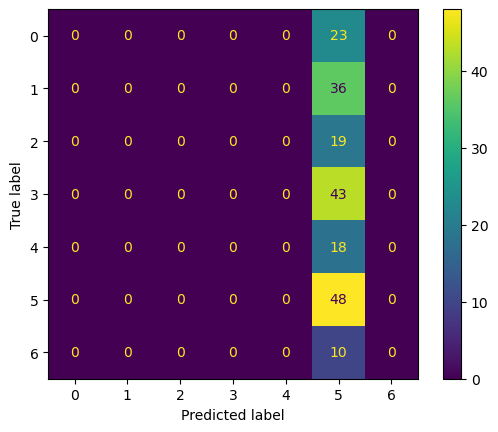

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_test, labels=svm_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_classifier.classes_)
disp.plot()
plt.show()

In [25]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_test)
report = classification_report(y_test, y_pred_test)

print("Test Accuracy:", accuracy)
print("Classification Report:\n", report)

Test Accuracy: 0.2436548223350254
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.00      0.00      0.00        36
           2       0.00      0.00      0.00        19
           3       0.00      0.00      0.00        43
           4       0.00      0.00      0.00        18
           5       0.24      1.00      0.39        48
           6       0.00      0.00      0.00        10

    accuracy                           0.24       197
   macro avg       0.03      0.14      0.06       197
weighted avg       0.06      0.24      0.10       197



C:\Users\vvsst\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vvsst\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vvsst\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(64,128), activation='relu', solver='adam', max_iter=750, random_state=1)
clf.fit(X_train,y_train)

C:\Users\vvsst\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (750) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(64, 128), max_iter=750, random_state=1)

In [27]:
y_pred_train = clf.predict(X_train)

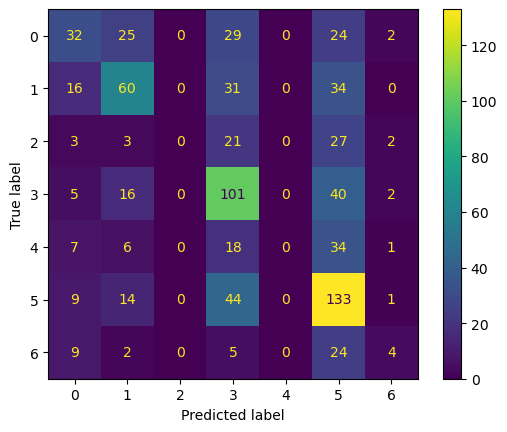

In [28]:
cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [29]:
# Evaluate the model
accuracy = accuracy_score(y_train, y_pred_train)
report = classification_report(y_train, y_pred_train)

print("Train Accuracy:", accuracy)
print("Classification Report:\n", report)

Train Accuracy: 0.42091836734693877
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.29      0.33       112
           1       0.48      0.43      0.45       141
           2       0.00      0.00      0.00        56
           3       0.41      0.62      0.49       164
           4       0.00      0.00      0.00        66
           5       0.42      0.66      0.51       201
           6       0.33      0.09      0.14        44

    accuracy                           0.42       784
   macro avg       0.29      0.30      0.28       784
weighted avg       0.35      0.42      0.37       784



C:\Users\vvsst\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vvsst\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vvsst\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
y_pred_test  = clf.predict(X_test)

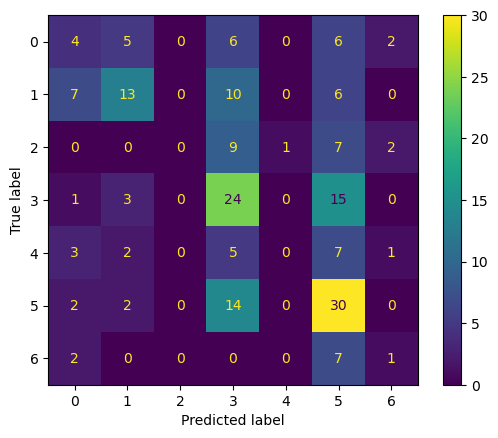

In [31]:
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [32]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_test)
report = classification_report(y_test, y_pred_test)

print("Test Accuracy:", accuracy)
print("Classification Report:\n", report)

Test Accuracy: 0.36548223350253806
Classification Report:
               precision    recall  f1-score   support

           0       0.21      0.17      0.19        23
           1       0.52      0.36      0.43        36
           2       0.00      0.00      0.00        19
           3       0.35      0.56      0.43        43
           4       0.00      0.00      0.00        18
           5       0.38      0.62      0.48        48
           6       0.17      0.10      0.12        10

    accuracy                           0.37       197
   macro avg       0.23      0.26      0.24       197
weighted avg       0.30      0.37      0.32       197



C:\Users\vvsst\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vvsst\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vvsst\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
